In [95]:
import requests, json
import pandas as pd
import numpy as np
from datetime import date, timedelta

headers = {
'Accept': 'application/x-google-protobuf',
'Authorization': 'apikey vy2rFNXj4MRr2fuPWkB9etPZlz2yiD7NoWHl',
}

df_res = pd.DataFrame()
all_res = []

def get_carspaces(facility,date):

    url = f'https://api.transport.nsw.gov.au/v1/carpark/history?facility={facility}&eventdate={date}'

    response = requests.get(url, headers=headers, stream=True)
    
    json_string = json.loads(response.content)

    list_of_available = []
    list_timestamp = []
    df_car_spaces = pd.DataFrame()
    for x in range(len(json_string)):
        total = json_string[x]['occupancy']['total']
        timestamp = json_string[x]['MessageDate']
        spots = json_string[x]['spots']
        list_of_available.append( int(spots) - int(total))
        list_timestamp.append( timestamp)
    
    df_car_spaces['Timestamp'] = list_timestamp
    df_car_spaces['Available'] = list_of_available
    all_res.append(df_car_spaces)
    #df_car_spaces.to_csv(f'../Resources/car_spaces{date}.csv')

# Parse date range
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

# Set start and end datetimes of 1 month 
start_date = date(2022, 3, 11)
end_date = date(2022, 4, 18)
for single_date in daterange(start_date, end_date):
    #print(single_date.strftime("%Y-%m-%d"))
    # 14 - West Ryde Car Park
    get_carspaces(14,single_date)

df_res = pd.concat(all_res)
#df_res.to_csv('../Resources/carspaces_data.csv')

In [79]:
df_res.set_index(df_res['Timestamp'], inplace=True)
del df_res['Timestamp']
df_res.tail()

,Available
Timestamp,
2022-04-17T23:16:15,142
2022-04-17T23:26:17,142
2022-04-17T23:33:27,143
2022-04-17T23:43:27,143
2022-04-17T23:53:29,143


In [80]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [81]:
# Define the window size
window_size = 280

# Set the index of the feature and target columns
feature_column = 0
target_column = 0

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(df_res, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[148 148 148 148 148 148 148 148 148 148 148 148 148 148 148 148 148 148
  148 148 148 148 148 148 148 148 148 147 147 147 146 145 145 144 143 142
  141 140 139 138 137 136 135 134 133 132 131 130 131 131 130 129 128 127
  128 127 126 125 126 125 124 123 122 121 120 119 118 117 116 115 114 113
  112 111 110 109 108 107 106 105 104 105 106 107 106 105 106 105 106 107
  107 108 107 108 107 106 105 104 103 102 101 101 100  99  98  97  96  97
   96  95  94  93  92  91  90  89  90  89  88  87  86  85  84  83  82  83
   82  81  80  79  78  78  79  79  78  77  76  76  75  74  73  72  71  72
   71  70  69  68  67  68  69  68  67  66  67  66  67  66  65  65  64  63
   63  64  63  63  62  61  62  62  61  62  61  60  59  60  59  58  58  58
   57  58  59  60  59  60  61  60  60  59  58  59  60  61  60  61  60  61
   60  59  60  60  60  61  62  63  62  63  64  63  64  63  63  64  63  64
   65  66  67  67  67  66  65  66  67  68  69  70  69  70  69  70  71  72
   73  74  75  74  75

In [82]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [83]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train

scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [84]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train.shape} \n")
print (f"X_test sample values:\n{X_test.shape}")

X_train sample values:
(10587, 280, 1) 

X_test sample values:
(4538, 280, 1)


In [86]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [87]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 64
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [88]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")
# Show the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 280, 64)           16896     
                                                                 
 dropout_3 (Dropout)         (None, 280, 64)           0         
                                                                 
 lstm_4 (LSTM)               (None, 280, 64)           33024     
                                                                 
 dropout_4 (Dropout)         (None, 280, 64)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [89]:
# Train the model
prediction = model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=40, verbose=1)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
265/265 [==============================] - 120s 436ms/step - loss: 0.0183
Epoch 2/10
265/265 [==============================] - 123s 465ms/step - loss: 0.0146
Epoch 3/10
265/265 [==============================] - 126s 474ms/step - loss: 0.0077
Epoch 4/10
265/265 [==============================] - 127s 479ms/step - loss: 0.0069
Epoch 5/10
265/265 [==================

In [90]:
# Evaluate the model: 0.034360241144895554
scores = model.evaluate(X_test, y_test, verbose=0)

#print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# save model and architecture to single file
model.save("model_40.h5")
print("Saved model to disk")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Saved model to disk


(4452, 280, 1)

In [91]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

# Recover the original prices instead of the scaled version
predicted_carspaces = scaler.inverse_transform(predicted)
real_spaces = scaler.inverse_transform(y_test.reshape(-1, 1))

forecast = model.predict(X_test[-200:])
forecast_carspaces = scaler.inverse_transform(forecast)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [92]:
# Create a DataFrame of Real and Predicted values
carspaces = pd.DataFrame({
    "Actual": real_spaces.ravel(),
    "Predicted": predicted_carspaces.ravel()
}, index = df_res.index[-len(real_spaces): ]) 

# Show the DataFrame's head
carspaces.tail()

,Actual,Predicted
Timestamp,,
2022-04-17T23:16:15,142.0,130.414841
2022-04-17T23:26:17,142.0,130.708832
2022-04-17T23:33:27,143.0,130.988556
2022-04-17T23:43:27,143.0,131.270493
2022-04-17T23:53:29,143.0,131.547073


<AxesSubplot:title={'center':'Actual Vs. Predicted Car Spaces'}, xlabel='Timestamp'>

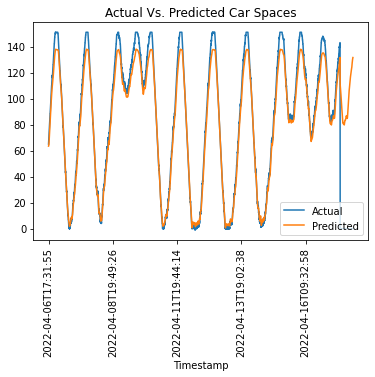

In [93]:
forecast_period = pd.date_range(df_res.index[-1], periods=200, freq='5min').tolist()

df_forecast = pd.DataFrame({'Timestamp':np.array(forecast_period), 'Predicted':forecast_carspaces.flatten()})
df_forecast.set_index(df_forecast['Timestamp'], inplace=True)
df_forecast =  df_forecast.drop(columns='Timestamp')
#carspaces = pd.concat([carspaces,df_forecast])
carspaces = pd.concat([carspaces,df_forecast])
carspaces['Actual'] = carspaces['Actual'].fillna(0)
carspaces.plot(title="Actual Vs. Predicted Car Spaces",rot=90)
#ax = carspaces.plot(title="Actual Vs. Predicted Car Spaces",rot=90)

#df_forecast.head()
#df_forecast.plot(ax=ax,label = 'forecast')

In [94]:
carspaces.to_csv('../Resources/available_spaces_forecast_18042022.csv')